In [36]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [9]:
df = pd.read_csv('C:/Users/86427/Desktop/MA415/Dataset/Airlines.csv')
df=df.drop("Users Reviews",axis=1)
df=df.fillna(0)
df.head(3)

,Aircraft Type,Country,Type_of_Travellers,Route,Seat_Types,Seat Comfort,Date Flown,Cabin Staff Service,Ground Service,Food & Beverages,Wifi & Connectivity,Inflight Entertainment,Value For Money,Recommended
0,0,United Kingdom,Couple Leisure,London Heathrow to Tokyo,Economy Class,1.0,Sep-23,1.0,2.0,1.0,0.0,3.0,1,no
1,0,United States,Solo Leisure,Miami to Dublin via London Heathrow,Business Class,1.0,Aug-23,3.0,1.0,2.0,1.0,1.0,1,no
2,0,United States,Business,Prague to San Francisco via London,Business Class,1.0,Sep-23,3.0,1.0,3.0,1.0,0.0,1,no


In [11]:
print(df.columns)

Index(['Aircraft Type', 'Country', 'Type_of_Travellers', 'Route', 'Seat_Types',
       'Seat Comfort', 'Date Flown', 'Cabin Staff Service', 'Ground Service',
       'Food & Beverages', 'Wifi & Connectivity', 'Inflight Entertainment',
       'Value For Money', 'Recommended'],
      dtype='object')


In [13]:
accuracy = df.Recommended.value_counts().no / (df.Recommended.value_counts().no + df.Recommended.value_counts().yes)
print('Baseline Accuracy:', 1- accuracy.round(3))

Baseline Accuracy: 0.387


In [15]:
df[["Seat Comfort", "Cabin Staff Service", "Ground Service", "Food & Beverages", 
    "Wifi & Connectivity", "Inflight Entertainment", "Value For Money"]] = df[["Seat Comfort",
                                                                               "Cabin Staff Service",
                                                                               "Ground Service",
                                                                               "Food & Beverages",
                                                                               "Wifi & Connectivity",
                                                                               "Inflight Entertainment",
                                                                               "Value For Money"]].apply(pd.to_numeric, errors='coerce')

In [17]:
average_ratings = df.groupby(['Seat_Types'], dropna=False)[["Seat Comfort",
                                                                                  "Cabin Staff Service",
                                                                                  "Ground Service",
                                                                                   "Food & Beverages",
                                                                                   "Wifi & Connectivity",
                                                                                   "Inflight Entertainment",
                                                                                   "Value For Money"]].mean(numeric_only=True)

print("Average Ratings based on 'Seat_Types':")
print(average_ratings)

Average Ratings based on 'Seat_Types':
                 Seat Comfort  Cabin Staff Service  Ground Service  \
Seat_Types                                                           
0                    1.000000             2.666667        0.333333   
Business Class       2.788314             3.356322        2.448276   
Economy Class        2.572669             2.889404        2.337001   
First Class          3.607143             3.877551        2.474490   
Premium Economy      2.918750             2.990625        2.446875   

                 Food & Beverages  Wifi & Connectivity  \
Seat_Types                                               
0                        1.666667             0.666667   
Business Class           2.761494             0.383142   
Economy Class            2.034163             0.303416   
First Class              3.086735             0.316327   
Premium Economy          2.471875             0.471875   

                 Inflight Entertainment  Value For Money  
Seat

In [19]:
train,test = train_test_split(df, train_size=0.8, random_state=1)

In [21]:
X_train = train.drop('Recommended', axis=1)
X_train = pd.get_dummies(X_train)

X_test = test.drop('Recommended', axis=1)
X_test = pd.get_dummies(X_test)

y_train = train.Recommended
y_test = test.Recommended

In [23]:
common_features = list(set(X_train.columns) & set(X_test.columns))

X_train = X_train[common_features]
X_test = X_test[common_features]

In [25]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200],
    'max_depth': [5, 10, 15, 20]
}

rfc = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 60, 70,
                                          80, 90, 100, 150, 200]},
             scoring='accuracy')

In [26]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best hyperparameters:", best_params)
print("Best score:", best_score)

Best hyperparameters: {'max_depth': 20, 'n_estimators': 80}
Best score: 0.9304701986277154


In [27]:
best_rfc = RandomForestClassifier(**best_params)
best_rfc.fit(X_train, y_train)

accuracy = best_rfc.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.925531914893617


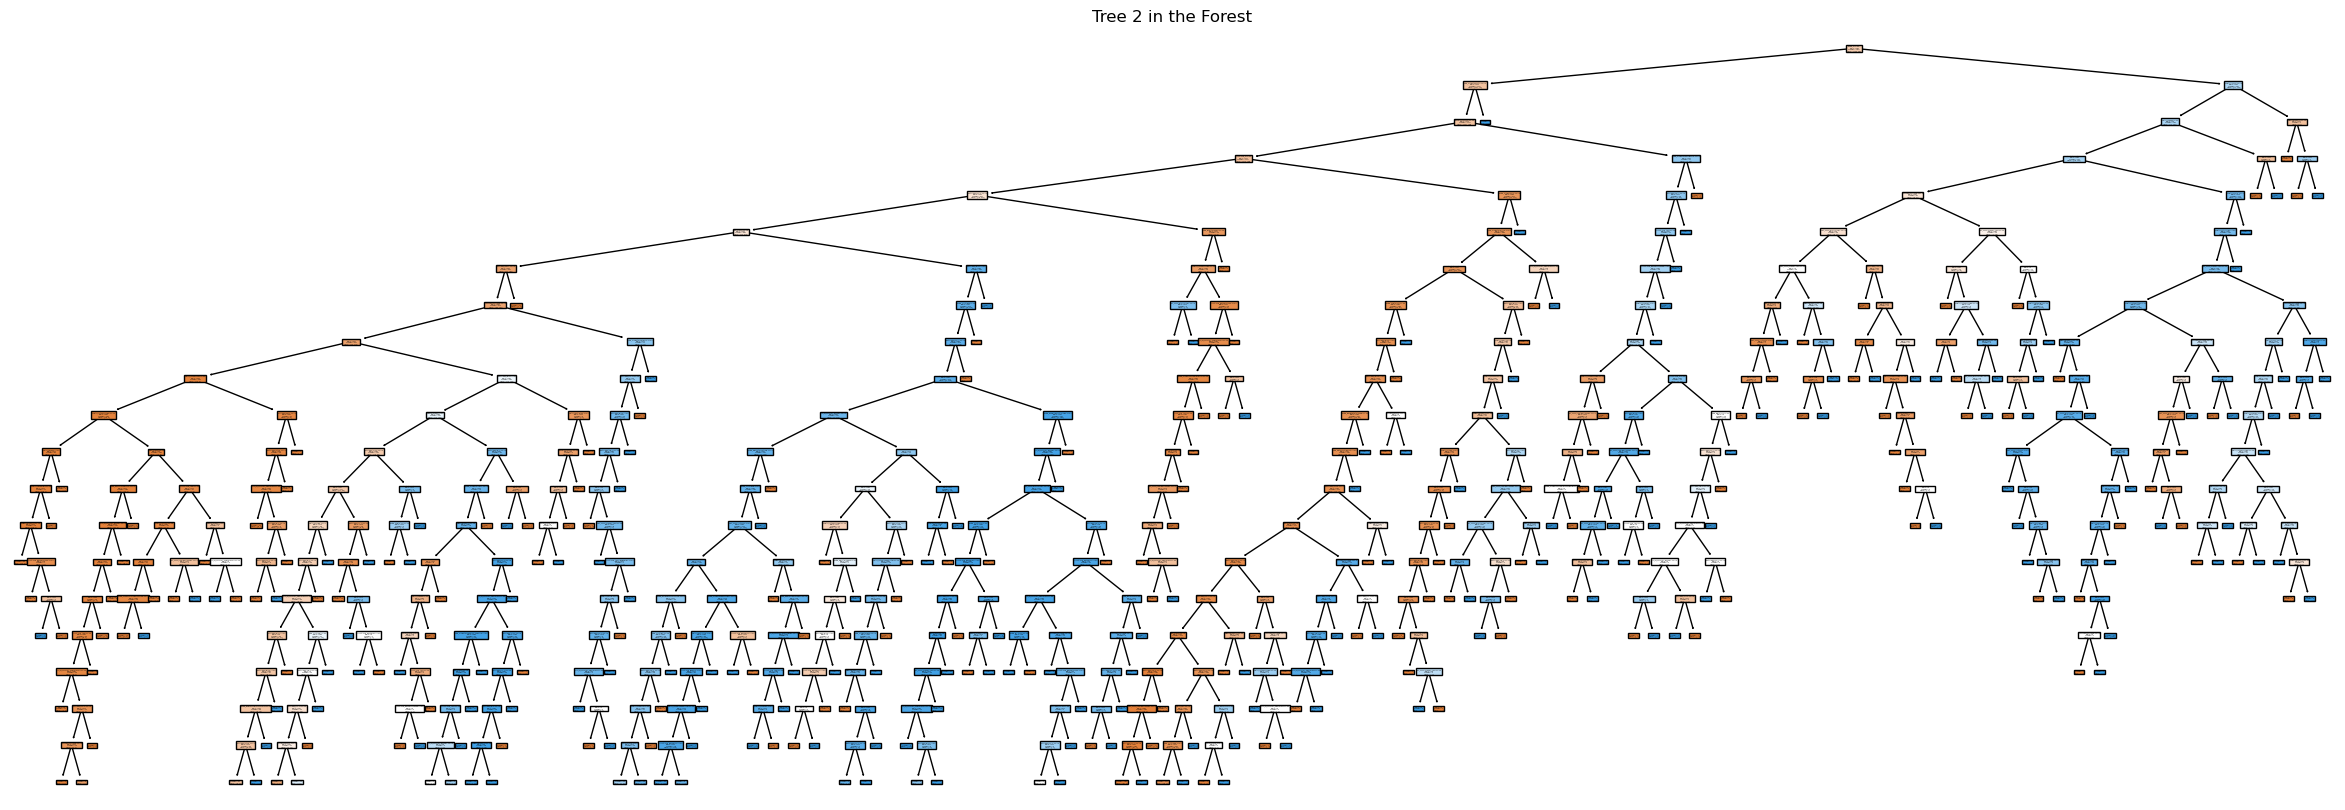

In [28]:
plt.figure(figsize=(30, 10))
tree_index = 2
plot_tree(best_rfc.estimators_[tree_index], filled=True, feature_names=X_train.columns)
plt.title(f"Tree {tree_index} in the Forest")
plt.show()

In [29]:
features_importance = pd.Series(best_rfc.feature_importances_, index=X_train.columns)
features_importance.sort_values(ascending=False)

Value For Money                   0.262307
Food & Beverages                  0.138681
Seat Comfort                      0.113893
Cabin Staff Service               0.113589
Ground Service                    0.086852
                                    ...   
Date Flown_Apr-20                 0.000000
Route_NAP to LGW                  0.000000
Route_London Heathrow to Accra    0.000000
Date Flown_Nov-20                 0.000000
Route_London to Las Vegas         0.000000
Length: 426, dtype: float64

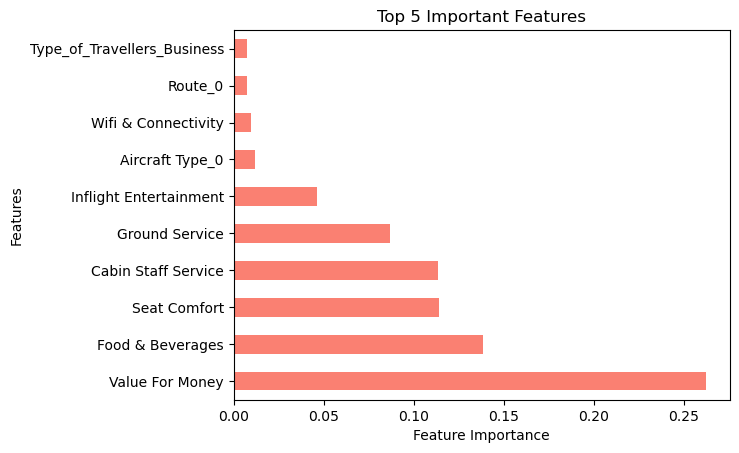

In [30]:
non_zero_importances = features_importance[features_importance > 0]

non_zero_importances.sort_values(ascending=False).head(10).plot.barh(color='salmon')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Important Features')
plt.show()